## **Libraries**

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## **Import Dataset**

In [3]:
df=pd.read_csv("mbti_dataset.csv")

In [4]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## **Preprocessing data**

In [22]:
df["target_EI"]=df["type"].apply(lambda row: row[0])
df["target_NS"]=df["type"].apply(lambda row: row[1])
df["target_TF"]=df["type"].apply(lambda row: row[2])
df["target_PJ"]=df["type"].apply(lambda row: row[3])

In [23]:
df.head()

,type,posts,target_EI,target_NS,target_TF,target_PJ
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,I,N,F,J
1,ENTP,'I'm finding the lack of me in these posts ver...,E,N,T,P
2,INTP,'Good one _____ https://www.youtube.com/wat...,I,N,T,P
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",I,N,T,J
4,ENTJ,'You're fired.|||That's another silly misconce...,E,N,T,J


In [57]:
y1=[]
y2=[]
barWidth = 0.4
r1 = range(len(y1))
r2 = [x + barWidth for x in r1]

In [58]:
y1.append(df["target_EI"].value_counts()[0])
y2.append(df["target_EI"].value_counts()[1])

In [59]:
y1.append(df["target_NS"].value_counts()[0])
y2.append(df["target_NS"].value_counts()[1])

In [60]:
y1.append(df["target_TF"].value_counts()[0])
y2.append(df["target_TF"].value_counts()[1])

In [61]:
y1.append(df["target_PJ"].value_counts()[0])
y2.append(df["target_PJ"].value_counts()[1])

Text(0.5, 1.0, 'Category P/J')

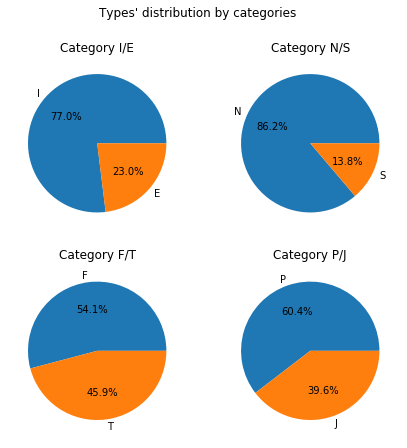

In [165]:
fig,ax = plt.subplots(2,2,figsize=(7,7))
fig.suptitle("Types' distributions by categories")
ax[0, 0].pie([y1[0],y2[0]], labels = ['I', 'E'],autopct='%1.1f%%')
ax[0, 0].set_title('Category I/E')
ax[0, 1].pie([y1[1],y2[1]], labels = ['N', 'S'],autopct='%1.1f%%')
ax[0, 1].set_title('Category N/S')
ax[1, 0].pie([y1[2],y2[2]], labels = ['F', 'T'],autopct='%1.1f%%')
ax[1, 0].set_title('Category F/T')
ax[1, 1].pie([y1[3],y2[3]], labels = ['P', 'J'],autopct='%1.1f%%')
ax[1, 1].set_title('Category P/J')

Categories FT and PJ are quite balanced. Accurracy will be adequate.
However, types E and S are underrepresented in their respective categories, so f1_score will be better these categories.

### **Clean Data**

In [102]:
stop_words = stopwords.words("english")
#create an object of class PorterStemmer
porter = PorterStemmer()

In [103]:
def cleanData(posts):
    # Lowercase
    clean_text = posts.lower()
    #remove all hyperlinks
    clean_text = re.sub(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})','',clean_text)
    word_list = word_tokenize(clean_text)
    clean_posts = []
    for word in word_list:
        if word.isalpha() and word not in stop_words:
            word = porter.stem(word)
            clean_posts.append(word)
    return clean_posts


In [104]:
df["posts_preprocessed"]= df["posts"].apply(lambda row: cleanData(row))

## **Models**

### **Vectorization**

In [309]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [310]:
X=df["posts_preprocessed"].map(' '.join)

In [109]:
cnt_vector = cv.fit_transform(X)
tfidf_vector = tfidf.fit_transform(X)

In [152]:
vectors={'cnt_vector':cnt_vector,'tfidf_vector':tfidf_vector}

In [ ]:
X_train_EI,X_test_EI,y_train_EI,y_test_EI = train_test_split(cnt_vector,df["target_EI"],test_size=0.2)


### **Predictions**

We will test the following classifiers for each category:
 * RandomForestClassifier
 * GaussianNb
 * MultinomialNB
 * LinearSVC
 * LogisticRegression

In [230]:
classifiers = [
    RandomForestClassifier(),
    GaussianNB(),
    MultinomialNB(),
    LinearSVC(dual=False),
    LogisticRegression(max_iter=1000,solver='liblinear')
    ]

**EI category**:

In [236]:

EI_f1_scores={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_EI"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        f1=metrics.f1_score(y_test,predictions,zero_division=0,average='macro')
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        EI_f1_scores[model_name_clean]=f1
        print(model_name)
        print(classification)


cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           E       0.00      0.00      0.00       393
           I       0.77      1.00      0.87      1342

    accuracy                           0.77      1735
   macro avg       0.39      0.50      0.44      1735
weighted avg       0.60      0.77      0.67      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           E       0.25      0.11      0.16       393
           I       0.78      0.90      0.83      1342

    accuracy                           0.72      1735
   macro avg       0.51      0.51      0.49      1735
weighted avg       0.66      0.72      0.68      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           E       0.59      0.31      0.41       393
           I       0.82      0.94      0.88      1342

    accuracy                           0.79      1735
   macro avg       0.70      0.62      0.

**NS category:**

In [240]:
NS_f1_scores ={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_NS"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        f1=metrics.f1_score(y_test,predictions,zero_division=0,average='macro')
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        NS_f1_scores[model_name_clean]=f1
        print(model_name)
        print(classification)

cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           N       0.86      1.00      0.92      1484
           S       0.00      0.00      0.00       251

    accuracy                           0.86      1735
   macro avg       0.43      0.50      0.46      1735
weighted avg       0.73      0.86      0.79      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           N       0.86      0.98      0.92      1484
           S       0.26      0.04      0.07       251

    accuracy                           0.84      1735
   macro avg       0.56      0.51      0.49      1735
weighted avg       0.77      0.84      0.79      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           N       0.87      0.97      0.92      1484
           S       0.43      0.14      0.21       251

    accuracy                           0.85      1735
   macro avg       0.65      0.55      0.

**TF category:**

In [242]:
TF_acc={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_TF"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        acc=metrics.accuracy_score(y_test,predictions)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        TF_acc[model_name_clean]=acc
        print(model_name)
        print(classification)
        


cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           F       0.70      0.89      0.78       924
           T       0.82      0.57      0.67       811

    accuracy                           0.74      1735
   macro avg       0.76      0.73      0.73      1735
weighted avg       0.75      0.74      0.73      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           F       0.61      0.54      0.57       924
           T       0.54      0.61      0.57       811

    accuracy                           0.57      1735
   macro avg       0.58      0.58      0.57      1735
weighted avg       0.58      0.57      0.57      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           F       0.80      0.84      0.82       924
           T       0.80      0.76      0.78       811

    accuracy                           0.80      1735
   macro avg       0.80      0.80      0.

**PJ category:**

In [244]:
PJ_acc={}
for i in vectors:
    X_train,X_test,y_train,y_test = train_test_split(vectors[i],df["target_PJ"],test_size=0.2)
    for classifier in classifiers:
        if str(classifier) == "GaussianNB()":
            X_train=X_train.todense()
            X_test=X_test.todense()
        model = classifier.fit(X_train, y_train)
        predictions=model.predict(X_test)
        acc=metrics.accuracy_score(y_test,predictions)
        classification=metrics.classification_report(y_test,predictions,zero_division=0)
        model_name = i +"+"+str(classifier)
        model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
        PJ_acc[model_name_clean]=acc
        print(model_name)
        print(classification)

cnt_vector+RandomForestClassifier()
              precision    recall  f1-score   support

           J       0.81      0.14      0.24       696
           P       0.63      0.98      0.77      1039

    accuracy                           0.64      1735
   macro avg       0.72      0.56      0.50      1735
weighted avg       0.70      0.64      0.55      1735

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           J       0.47      0.42      0.44       696
           P       0.64      0.68      0.66      1039

    accuracy                           0.58      1735
   macro avg       0.55      0.55      0.55      1735
weighted avg       0.57      0.58      0.57      1735

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           J       0.70      0.62      0.65       696
           P       0.76      0.82      0.79      1039

    accuracy                           0.74      1735
   macro avg       0.73      0.72      0.

As said before, we have to look at precision for JP category. It seems that tfidf_vector() + LinearSVC() fit better the category

In [299]:
print(list(EI_f1_scores.keys())[0])

cnt_vector+RandomForestClassifier


## **Conclusion**

We will compare the differents models for each category.
As seen before, for the categories E/I and N/S we are interesting in f1_score results. For T/F and P/J, we are focus on accuracy.

Text(0.5, 1.0, "models' accuracies for P/J category")

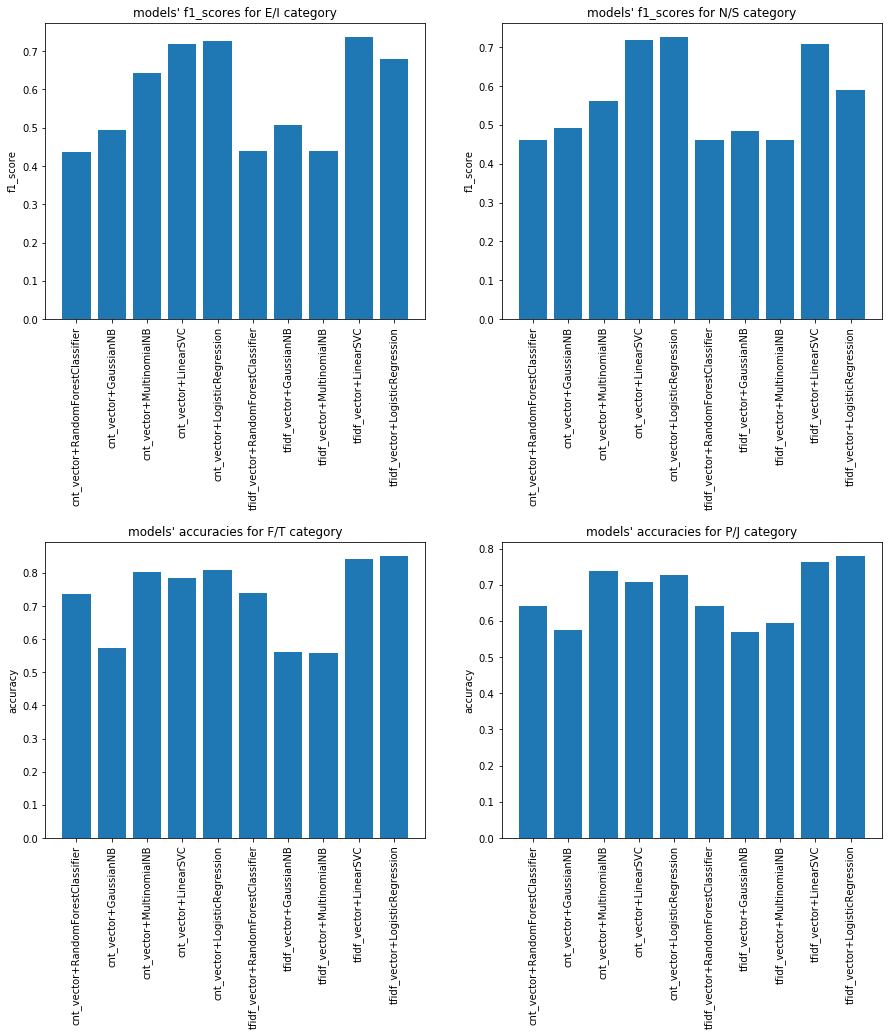

In [308]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
fig.subplots_adjust(hspace=0.75)

ax[0, 0].bar(range(len(EI_f1_scores)),list(EI_f1_scores.values()), align='center')
ax[0, 0].set_xticks(range(len(EI_f1_scores)))
ax[0, 0].set_xticklabels([list(EI_f1_scores.keys())[x] for x in range(len(EI_f1_scores))], rotation=90)
ax[0, 0].set_ylabel("f1_score")
ax[0, 0].set_title("models' f1_scores for E/I category")

ax[0, 1].bar(range(len(NS_f1_scores)), list(NS_f1_scores.values()), align='center')
ax[0, 1].set_xticks(range(len(NS_f1_scores)))
ax[0, 1].set_xticklabels([list(NS_f1_scores.keys())[x] for x in range(len(NS_f1_scores))], rotation=90)
ax[0, 1].set_ylabel("f1_score")
ax[0, 1].set_title("models' f1_scores for N/S category")

ax[1, 0].bar(range(len(TF_acc)), list(TF_acc.values()), align='center')
ax[1, 0].set_xticks(range(len(TF_acc)))
ax[1, 0].set_xticklabels([list(TF_acc.keys())[x] for x in range(len(TF_acc))], rotation=90)
ax[1, 0].set_ylabel("accuracy")
ax[1, 0].set_title("models' accuracies for F/T category")

ax[1, 1].bar(range(len(PJ_acc)), list(PJ_acc.values()), align='center')
ax[1, 1].set_xticks(range(len(PJ_acc)))
ax[1, 1].set_xticklabels([list(PJ_acc.keys())[x] for x in range(len(PJ_acc))], rotation=90)
ax[1, 1].set_ylabel("accuracy")
ax[1, 1].set_title("models' accuracies for P/J category")

**As we can see on the bar charts above, tfidf_vector+LinearSVC() is the model which fit well all the categories.**